In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Clase 

In [58]:
class DelayModel:
    def __init__(self, u_k, y_k, prior_times, delay_prior, prior_parameters, prior_noise,order):
        self.u = u_k
        self.y = y_k
        self.noise = prior_noise
        self.delay_distribution = delay_prior
        self.order = order  #If order is 2: y_k = A* u_k + B u_{k-1} + C u_{k-2}
        try:
            self.num_params = u_k.shape[1]
        except: 
            self.num_params = 1
        self.parameters = prior_parameters
        self.Ti = prior_times    #Times at which the y_k are available
        self.q  = len(delay_prior)
        self.evaluate2 = False
        
        #Results
        self.w = None
        self.approx_delays = None
        self.log = {'noise': [prior_noise], 'params':[prior_parameters] }
        
        #Funcion
        self.M1 = None
        self.M2 = np.log(delay_prior)
        self.Q = None
        
    def model_eval_2(self, index, delay, params = None):
        value = 0
        if params is None:
            for i in range(len(self.parameters)):
                value += self.parameters[i]*self.u[self.Ti[index] - delay][i]
        else: 
            for i in range(len(params)):
                value += params[i]*self.u[self.Ti[index] - delay][i]
        return value
    def model_eval(self, index, delay, params = None): 
        if self.evaluate2 == True:
            value = self.model_eval_2(index,delay)
        else:
            value = 0
            if params is None:
                for i in range(len(self.parameters)):
                    value += self.parameters[i]*self.u[self.order + self.Ti[index] - delay -i]
            else: 
                for i in range(len(params)):
                    value += params[i]*self.u[self.order + self.Ti[index] - delay -i]
        return value
        
    def p(self, index, delay): #, params = None):
        return (1/(np.sqrt(2*np.pi)*self.noise) )* np.exp( -(1/(2*(self.noise)**2))*(self.y[index] - self.model_eval(index,delay) )**2)
#         else:
#             print("ole")
#             return (1/(np.sqrt(2*np.pi)*self.noise) )* np.exp( -(1/(2*(self.noise)**2))*(self.y[index] - self.model_eval(index,delay,params) )**2)
    
    def logp(self,index,delay, params = None):
        if params is None:
            return (-np.log(np.sqrt(2*np.pi)*self.noise) -((1/(2*(self.noise)**2))*(self.y[index] - self.model_eval(index,delay) )**2))
        else:
             return (-np.log(np.sqrt(2*np.pi)*self.noise) -((1/(2*(self.noise)**2))*(self.y[index] - self.model_eval(index,delay, params) )**2))
    def get_weights(self):
        w = np.zeros(shape = (len(self.y),self.q)) #Weights
        for i in range(len(self.y)):
            for j in range(self.q):
                numerador = self.p(i ,j)*self.delay_distribution[j]
                denominador = np.array([ self.p(i ,j)*self.delay_distribution[j] for j in range(self.q)]).sum()
                if denominador > 0.0:
                    w[i,j] = numerador/denominador
                else:
                    w[i,j] = 1/self.q
        self.w = w
    #np.array([[u_k[2+prior_times[i] -j] , u_k[2+prior_times[i] -j-1] ,u_k[2+prior_times[i] -j-2]]])
    def get_vector(self, i, j):
        if self.evaluate2 == True:
            l = [self.u[self.Ti[i] - j][k] for k in range(self.order+1)]
        else:
            l = [self.u[self.order + self.Ti[i] - j - k] for k in range(self.order+1)]
        return np.array([l])
    
    def get_Q(self):
        M = np.zeros(shape = (self.q, len(self.y)))
        for i in range(len(self.y)):
            for j in range(self.q):
                M[i,j] = self.logp(i,j)
        self.M1 = M
        
        s#elf.Q = lambda params:  
   
    def update_params(self):
        M = np.zeros(shape=(self.order+1,self.order+1))
        v = np.zeros(shape = (self.order+1,1))
        for i in range(len(self.y)):
            for j in range(self.q):
                psi = self.get_vector(i,j)
                #psi = np.array([u_k[2+ prior_times[i]-j-3:2+ prior_times[i]-j]
                #psi = np.flip(psi)
                M += self.w[i,j]*(psi.T.dot(psi))
                v += self.w[i,j]*self.y[i]*psi.T
                #v+= w[i,j]*y_k[i]*u_k[2+prior_times[i]-j-3:2+ prior_times[i]-j]
        #print(M)
        
        try:
            self.parameters = np.linalg.inv(M).dot(v)
        except np.linalg.LinAlgError:
            self.parameters = np.linalg.pinv(M).dot(v)
            
    def update_noise(self):
        noise = 0
        for i in range(len(self.y)):
            for j in range(self.q):
                noise += self.w[i,j]*(self.y[i] - self.model_eval(i,j) )**2
        self.noise = np.sqrt(noise)/np.sqrt(len(self.y))
        
        
    def EM(self, iters = 15, get_noise = True, get_log = False):
        for i in range(iters):
            self.get_weights()
            self.update_params()
            if get_noise == True:
                self.update_noise()
            if get_log == True:
                self.log['params'].append(self.parameters)
                if get_noise == True:
                    self.log['noise'].append(self.noise)
            
    def get_delays(self):
        approx_delays= []
        for i in range(self.w.shape[0]):
            approx_delays.append(np.argmax(self.w[i,:]))
        self.approx_delays = approx_delays
            

# Modelo

Suponemos un modelo de la forma:
    $x_k = 2 u_k - 1.5 u_{k-1} + 0.5 u_{k-2}$
Conde los $u_k$ son variables que se obtienen de forma "segura" en el tiempo, para el ejemplo serán variables aleatorias gaussianas independientes y de media $0$ y varianza $1$. Mientras que los $x_k$ son valores que nos gustaría obtener, pero del cual sólo tenemos una medición.

La medición supondremos que es de la forma:

$y_{T_i} = x_{T_i - \lambda_i} + r_i$
    
Donde el $T_i$ es el periodo medio de la muestra $T_i$, por ejemplo, si es una variable que se obtiene cada 12 horas, los $T_i$ serían los multiplos de 12. Y los $\lambda_i$ son perturbaciones que se hacen a dichas muestras de periodo. Por ejemplo si $\lambda_i$ fuese 1, significa que la medicion se realizo $1$ hora más temprano de lo anticipado. La variable $r_i$ es solo ruido gaussiano con alguna varianza determinada

First we generate the data, with parameters $(2,-1.5,0.5)$ to estimate

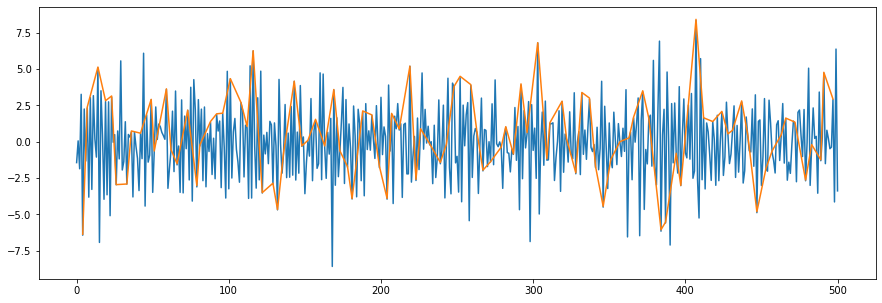

In [59]:
parameters = np.array([2,-1.5,0.5]) #, 3.1, -1.1, 0.3])
order = len(parameters)
u_k = np.random.randn(500 + order) #Los u_k, datos que estan definidos en todo tiempo
x_k = np.convolve(u_k, parameters)[order-1:-(order-1)]

#x_k = 2*u_k[2:] - 1.5*u_k[1:-1] + 0.5*u_k[:-2] 
times =np.arange(4,500,5) 
delays = []
sigma_v = .1
for i in range(len(times)):
    delay = np.random.randint(0,4)
    times[i] = times[i] - delay
    delays.append(delay)
y_k = x_k[times] + (sigma_v)*np.random.rand(len(times))
#u_k = u_k[2:]
plt.figure(figsize= (15,5))
plt.plot(x_k)
plt.plot(times,y_k)
plt.show()


Definimos los parametros para nuestro algoritmo, y ocupamos la clase para obtener los resultados

In [60]:
delay_prior = np.array([0.25,0.25,0.25,0.25])
prior_noise = 1
#prior_parameters = np.array([28.0,-1.0, 23]) #,0.5])
prior_parameters = np.random.rand(len(parameters))+1
prior_times =  times + delays

model = DelayModel(u_k, y_k, prior_times, delay_prior, prior_parameters,prior_noise, len(prior_parameters)-1)
model.EM(iters = 10, get_log = True, get_noise = True)
model.get_delays()

In [61]:
model.parameters

array([[ 1.99723008],
       [-1.5132045 ],
       [ 0.42318166]])

# Resultados: Parametros del modelo

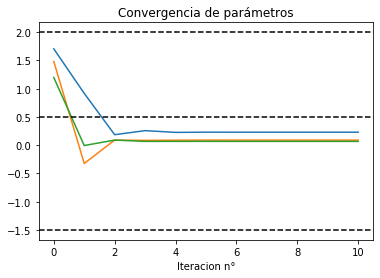

In [57]:
paramis = []
for j in range(len(model.parameters)):
    pars = np.array([model.log['params'][i][j] for i in range(len(model.log['params']))])
    paramis.append(pars)
plt.title('Convergencia de parámetros')
for parami in paramis:
    plt.plot(parami)
for param in parameters:
    plt.axhline(y=param, linestyle = 'dashed', color ='k')
plt.xlabel('Iteracion n°')
plt.show()

# Resultados: Tiempos de delay

Media del error: 0.23 
 Desviación estándar del error: 1.4687069142616576
Probabilidad de acierto: 0.33


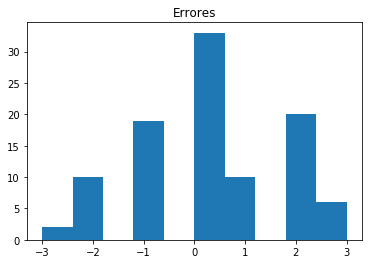

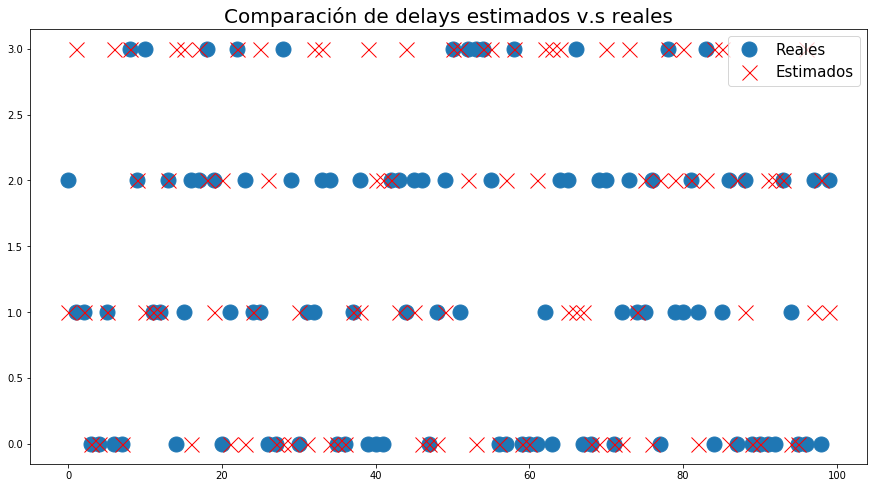

In [20]:
approx_delays = model.approx_delays
    
print('Media del error:',(np.array(approx_delays) - np.array(delays)).mean(),'\n','Desviación estándar del error:',(np.array(approx_delays) - np.array(delays)).std()) 
print('Probabilidad de acierto:', ((np.array(approx_delays) - np.array(delays))==0).sum()/len(delays)  )
plt.title('Errores')
plt.hist(np.array(approx_delays) - np.array(delays))
plt.show()

plt.figure(figsize=(15,8))
plt.title('Comparación de delays estimados v.s reales', fontsize=20)
plt.plot(delays,'o', label ='Reales', markersize=15)
plt.plot(approx_delays,'x',label = 'Estimados', markersize=15, color ='r')
plt.legend(fontsize=15)
plt.show()

# Segundo Experimento: Multiples variables

In [ ]:
parameters = np.array([2,-1.5,0.5]) #, 3.1, -1.1, 0.3])
order = len(parameters)
u_k = np.random.randn(500 + order,len(parameters)) #Los u_k, datos que estan definidos en todo tiempo


#x_k = np.convolve(u_k, parameters)[order-1:-(order-1)]

x_k = u_k.dot(parameters)

times =np.arange(4,500,5) 
delays = []
sigma_v = 0.1
for i in range(len(times)):
    delay = np.random.randint(0,4)
    times[i] = times[i] - delay
    delays.append(delay)
y_k = x_k[times] + (sigma_v)*np.random.rand(len(times))
#u_k = u_k[2:]
plt.figure(figsize= (15,5))
plt.plot(x_k)
plt.plot(times,y_k)
plt.show()


In [ ]:
delay_prior = np.array([0.25,0.25,0.25,0.25])
prior_noise = 0.1
#prior_parameters = np.array([28.0,-1.0, 23]) #,0.5])
prior_parameters = np.random.rand(len(parameters))
prior_times =  times + delays

model = DelayModel(u_k, y_k, prior_times, delay_prior, prior_parameters,prior_noise, len(prior_parameters)-1)
model.evaluate2 = True
model.EM(iters = 35, get_log = True,get_noise = True)
model.parameters
model.get_delays()

# Resultados

In [ ]:
paramis = []
for j in range(len(model.parameters)):
    pars = np.array([model.log['params'][i][j] for i in range(len(model.log['params']))])
    paramis.append(pars)
plt.title('Convergencia de parámetros')
for parami in paramis:
    plt.plot(parami)
for param in parameters:
    plt.axhline(y=param, linestyle = 'dashed', color ='k')
plt.xlabel('Iteracion n°')
plt.show()

In [ ]:
approx_delays = model.approx_delays
    
print('Media del error:',(np.array(approx_delays) - np.array(delays)).mean(),'\n','Desviación estándar del error:',(np.array(approx_delays) - np.array(delays)).std()) 
print('Probabilidad de acierto:', ((np.array(approx_delays) - np.array(delays))==0).sum()/len(delays)  )
plt.title('Errores')
plt.hist(np.array(approx_delays) - np.array(delays))
plt.show()

plt.figure(figsize=(15,8))
plt.title('Comparación de delays estimados v.s reales', fontsize=20)
plt.plot(delays,'o', label ='Reales', markersize=15)
plt.plot(approx_delays,'x',label = 'Estimados', markersize=15, color ='r')
plt.legend(fontsize=15)
plt.show()

In [ ]:
f =pd.read_csv('datos12_hrs.csv')
g =pd.read_csv('datos_2_hrs.csv')

In [ ]:
plt.plot((f['Promedio 12 Hrs']- f['Promedio 12 Hrs'].mean()) /f['Promedio 12 Hrs'].std() )
plt.plot((g['OF BH1 (%) Solid']- g['OF BH1 (%) Solid'].mean()) /g['OF BH1 (%) Solid'].std() )
plt.plot((g['OF BH2 (%) Solid']- g['OF BH2 (%) Solid'].mean()) /g['OF BH2 (%) Solid'].std() )